## Titanic Survival Prediction Using Machine Learning

### 1. Importing Libraries and Initial setup

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape

(891, 12)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### 2. Data Visualization: Understanding Survival Trends and Passenger Demographics

In [6]:
#visualize the number of survivors and death counts
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

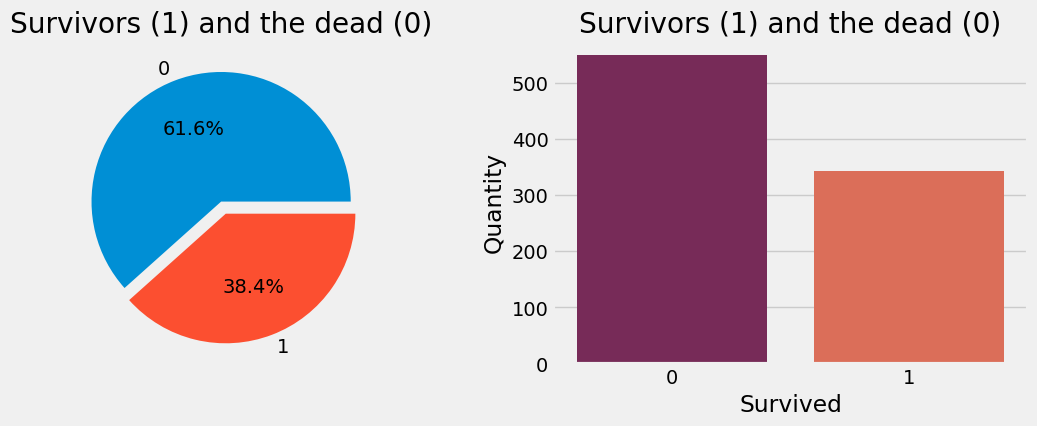

In [7]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct="%1.1f%%", shadow=False, ax=ax[0])
ax[0].set_title("Survivors (1) and the dead (0)")
ax[0].set_ylabel('')

sns.countplot(data=train, x='Survived', ax=ax[1], palette='rocket')
ax[1].set_title("Survivors (1) and the dead (0)")
ax[1].set_ylabel("Quantity")
plt.show()

In [8]:
# Analyzing the Impact of Sex on Survival Rates
train[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


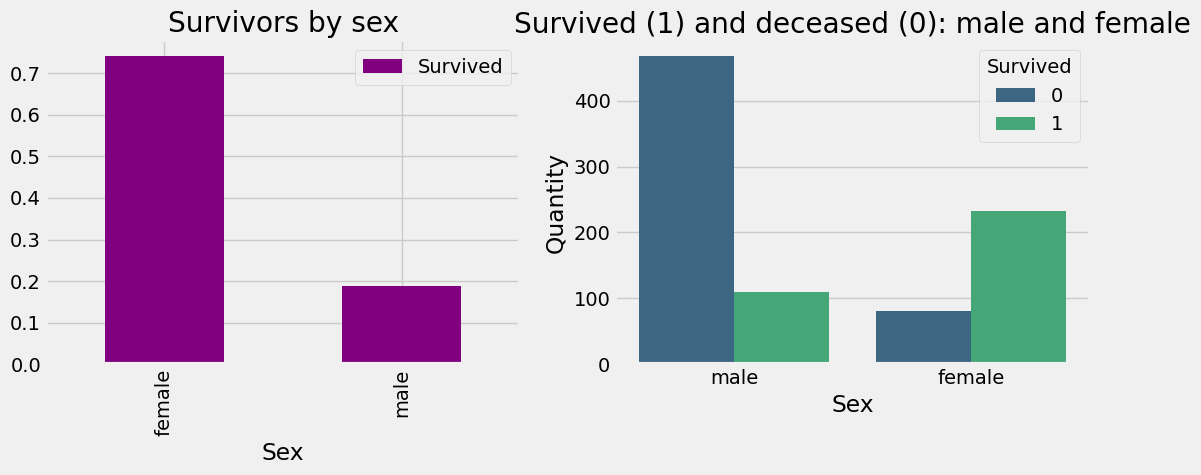

In [9]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0], color="purple")
ax[0].set_title("Survivors by sex")

sns.countplot(data=train, x='Sex', hue='Survived', ax=ax[1], palette="viridis")
ax[1].set_ylabel("Quantity")
ax[1].set_title("Survived (1) and deceased (0): male and female")
plt.show()

### 3. Feature Engineering: Optimizing Data for Model Training

In [10]:
train = train.drop(["Cabin"], axis=1)
test = test.drop(["Cabin"], axis=1)

In [11]:
train = train.drop(["Ticket"], axis=1)
test = test.drop(["Ticket"], axis=1)

In [12]:
train["Embarked"] = train["Embarked"].fillna("S")

In [13]:
# sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)

In [14]:
bins=[-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Adult', 'Young Adult', 'Senior']
train['AgeGroup'] = pd.cut(train['Age'], bins, labels=labels)
test['AgeGroup'] = pd.cut(test['Age'], bins, labels=labels)

In [15]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Young Adult


In [16]:
# create a combined group of both datasets
combine = [train, test]
# extract a title for each Name in the train and test datasets
for dataset in combine:
    dataset["Title"] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)
pd.crosstab(train["Title"], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [17]:
# replace various titles with more common names
for dataset in combine:
    dataset["Title"] = dataset["Title"].replace(['Lady', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 
                                               'Rare')
    dataset["Title"] = dataset["Title"].replace(['Countees', 'Lady', 'Sir'], 'Royal')
    dataset["Title"] = dataset["Title"].replace('Mlle', 'Miss')
    dataset["Title"] = dataset["Title"].replace('Ms', 'Miss')
    dataset["Title"] = dataset["Title"].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Countess,1.000000
1,Master,0.575000
2,Miss,0.702703
3,Mr,0.156673
4,Mrs,0.793651
5,Rare,0.285714
6,Royal,1.000000


In [18]:
# map each of the title groups to a numerical value
title_mapping = {
    "Mr": 1,
    "Miss": 2,
    "Mrs": 3,
    "Master": 4,
    "Royal": 5,
    "Rare": 6
}
for dataset in combine:
    dataset["Title"] = dataset["Title"].map(title_mapping)
    dataset["Title"] = dataset["Title"].fillna(0)

In [19]:
# Now using the title information we can fill in the missing age values
mr_age = train[train['Title'] == 1]['AgeGroup'].mode()  #Young Adult
miss_age = train[train['Title'] == 2]['AgeGroup'].mode()  #Student
mrs_age = train[train['Title'] == 3]['AgeGroup'].mode()  #Adult
master_age = train[train['Title'] == 4]['AgeGroup'].mode()  #Baby
royal_age = train[train['Title'] == 5]['AgeGroup'].mode()  #Adult
rare_age = train[train['Title'] == 6]['AgeGroup'].mode()  #Adult

age_title_mapping = {
    1: 'Young Adult',
    2: 'Student',
    3: 'Adult',
    4: 'Baby',
    5: 'Adult',
    6: 'Adult'
}

for x in range(len(train['AgeGroup'])):
    if train['AgeGroup'][x] == 'Unknown':
        train['AgeGroup'][x] = age_title_mapping[train['Title'][x]]

for x in range(len(test['AgeGroup'])):
    if test['AgeGroup'][x] == 'Unknown':
        test['AgeGroup'][x] = age_title_mapping[test['Title'][x]]

In [20]:
# Now assign a numerical value to each age category.
age_mapping = {
    'Baby': 1,
    'Child': 2, 
    'Teenager': 3,
    'Student': 4,
    'Young Adult': 5,
    'Adult': 6,
    'Senior': 7
}

train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

#train.head(2)

# dropping the Age feature for now, might change
train = train.drop(['Age'], axis=1)
test = test.drop(['Age'], axis=1)

In [21]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,7.2500,S,4.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,71.2833,C,5.0,3.0


In [22]:
# dropping the Name feature for now, might change
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

In [23]:
train.head(2)

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,Title
0,1,0,3,male,1,0,7.2500,S,4.0,1.0
1,2,1,1,female,1,0,71.2833,C,5.0,3.0


In [24]:
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [25]:
#Assign numerical values to sex and embarks categories
sex_mapping = {
    "male": 0,
    "female": 1
}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

In [26]:
embarked_mapping = {
    "S": 1,
    "C": 2,
    "Q": 3
}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

In [27]:
train.head(2)

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,Title
0,1,0,3,0,1,0,7.2500,1,4.0,1.0
1,2,1,1,1,1,0,71.2833,2,5.0,3.0


In [28]:
# Fill in the missing Fare value in the test set based on the mean fare for that P-class
for x in range(len(test['Fare'])):
    if pd.isnull(test['Fare'][x]):
        pclass = test['Pclass'][x]
        test['Fare'][x] = round(train[train['Pclass'] == pclass]['Fare'].mean())

# map Fare values into groups of 
# numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4, labels=[1, 2, 3 ,4])
test['FareBand'] = pd.qcut(test['Fare'], 4, labels=[1, 2, 3, 4])

# drop Fare values
train = train.drop(['Fare'], axis=1)
test = test.drop(['Fare'], axis=1)

### 4. Model Training: Building the Predictive Model

In [29]:
from sklearn.model_selection import train_test_split

predictors = train.drop(["Survived", "PassengerId"], axis=1)
target = train['Survived']

x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size=0.2, random_state=0)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_val)

acc_rf = round(accuracy_score(y_val, y_pred) * 100, 2)

print("Accuracy of Random Forest Classifier: ", acc_rf,"%")

Accuracy of Random Forest Classifier:  84.92 %


### Prediction: Generating Survival Predictions on Test Data

In [35]:
ids = test['PassengerId']
test_prediction = rf.predict(test.drop(['PassengerId'], axis=1))

# set the output as a dataframe and convert 
# to csv file named resultfile.csv
output = pd.DataFrame({
    'PassengerId': ids,
    'Survived': test_prediction
})
output.to_csv("resultfile.csv", index=False)